In [1]:
from datetime import datetime
import math
import pathlib

import corner
import emcee
import numpy as np
import pandas as pd

import itm.cosmology
from itm.posterior_calculator import PosteriorCalculator
import itm.utils

In [2]:
experiments = [
    "local_hubble",
    "cosmic_chronometers",
    "jla",
    "bao_compilation",
    "bao_wigglez",
]
# LCDM
# p0 = [24.96, 0.69, 0.022, 0.12]
# cosmo = itm.cosmology.LCDM()

# wCDM
p0 = [24.96, 0.69, 0.022, 0.12, -0.99]
cosmo = itm.cosmology.WCDM()

max_n = 50000

In [ ]:
# house keeping: running new model
RESULTS_BASE_DIR = pathlib.Path("results")
base_dir = cosmo.get_name() + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")

chains_path = os.path.join(RESULTS_BASE_DIR, base_dir, "chains.h5")

In [ ]:
%%time

config_params = itm.utils.load_config("/Users/fabio/code/fchibana/tachyons/config.yaml")
mcmc_params = config_params["mcmc_params"]


ndim = len(p0)
nwalkers = mcmc_params["n_walkers"]
# out_name = "results/" + datetime.now().strftime("%Y%m%d_%H%M%S")

backend = emcee.backends.HDFBackend(chains_path)
backend.reset(nwalkers, ndim)


# MCMC =============================================================================================
print("walkers: ", nwalkers)
prob = PosteriorCalculator(
    cosmology=cosmo, experiments=experiments
)  # TODO: if experiments==None, use all
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob.ln_posterior, backend=backend)

# condicoes iniciais dos walkers dentro da bola de centro p1_0
pos = [p0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    steps = sampler.iteration
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    # print(tau)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [2]:
def get_sample(sampler):
    tau = sampler.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
    # log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

    print(f"burn-in: {burnin}")
    print(f"thin: {thin}")
    print(f"flat chain shape: {flat_samples.shape}")
    print(f"flat log prob shape: {log_prob_samples.shape}")
    # print(f"flat log prior shape: {log_prior_samples.shape}")
    return flat_samples

In [ ]:
# Analysis ===========================================================================================
# tau = sampler.get_autocorr_time()
# burnin = int(2 * np.max(tau))
# thin = int(0.5 * np.min(tau))
# flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

## Load chains

In [6]:
base_dir = "wcdm_20220327_150304"
cosmo = itm.cosmology.WCDM()

In [3]:
chains_path = os.path.join(RESULTS_BASE_DIR, base_dir, "chains.h5")
reader = emcee.backends.HDFBackend(chains_path)
flat_samples = get_sample(reader)

burn-in: 220
thin: 32
flat chain shape: (10880, 5)
flat log prob shape: (10880,)


Text(0.5, 0.98, 'wcdm')

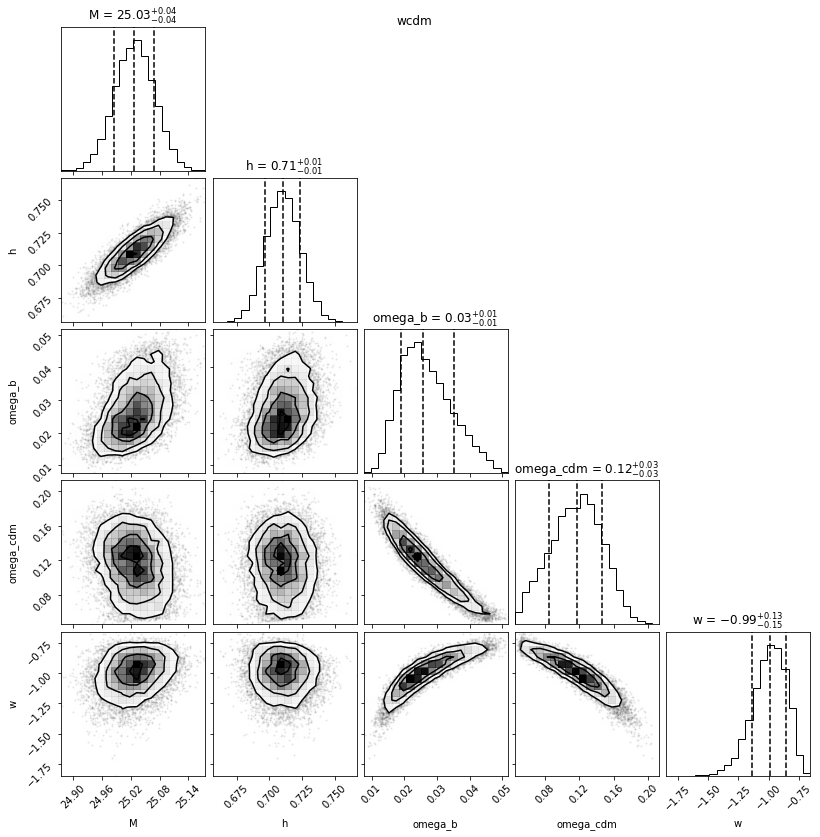

In [7]:
fig = corner.corner(
    flat_samples,
    # labels=["M", "$h$", "$\Omega_{b} h^2$", "$\Omega_{c} h^2$", "$w$"],
    labels=cosmo._params_names,
    quantiles=(0.16, 0.5, 0.84),
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
fig.suptitle(cosmo.get_name())
# fig.show()
plot_path = os.path.join(RESULTS_BASE_DIR, base_dir, "plot.png")
# fig.savefig(plot_path)

# Compute percentiles

In [9]:
def get_best_fit(samples, parameter_names=None):
    one_sigma_up = np.quantile(samples, q=0.84, axis=0)
    mean = np.quantile(samples, q=0.5, axis=0)
    one_sigma_down = np.quantile(samples, q=0.15, axis=0)

    err_up = one_sigma_up - mean
    err_down = mean - one_sigma_down

    if parameter_names is not None:
        assert samples.shape[1] == len(parameter_names)

    best_fit = pd.DataFrame(
        [mean, err_up, err_down],
        index=["best_fit", "err_up", "err_down"],
        columns=parameter_names,
    )
    return best_fit

In [11]:
best_fit = get_best_fit(flat_samples, cosmo._params_names)
best_fit

,M,h,omega_b,omega_cdm,w
best_fit,25.027536,0.710292,0.025732,0.117739,-0.986847
err_up,0.041550,0.013482,0.009399,0.028872,0.128181
err_down,0.043546,0.013973,0.006963,0.034583,0.158369


# Information criteria
```
# number of free parameters
k = 4

# number of data points
n = 74.

chi2 = -2.*lnlike(params) 
red_chi2 = chi2/(n-k)
aic = chi2 + 2.*k
bic = chi2 + k*np.log(n)

results = np.array([chi2, red_chi2,k, aic, bic])

header_string = 'chi2,reduced chi2, k, aic, bic'
np.savetxt("results/"+file_name+".modelselec", results, fmt='%1.6e', header=header_string)
```

In [13]:
n_data = 74.0  # TODO: create attribute in PosteriorCalculator
experiments = [
    "local_hubble",
    "cosmic_chronometers",
    "jla",
    "bao_compilation",
    "bao_wigglez",
]
prob = PosteriorCalculator(cosmology=cosmo, experiments=experiments)


def information_criterion(best_fit, fname=None):
    n_params = best_fit.shape[1]

    chi2 = -2.0 * prob._ln_likelihood(best_fit.loc["best_fit"])
    red_chi2 = chi2 / (n_data - n_params)
    aic = chi2 + 2.0 * n_params
    bic = chi2 + n_params * math.log(n_data)

    print("Model: ", cosmo.get_name())
    print(f"  n. parameters: {n_params}")
    print(f"  chi2: {chi2:.2f}")
    print(f"  reduced chi2: {red_chi2:.2f}")
    print(f"  AIC: {aic:.2f}")
    print(f"  BIC: {bic:.2f}")

    # save to disk
    if fname is not None:
        df = pd.DataFrame(
            {
                "model": [cosmo.get_name()],
                "n_parameters": [n_params],
                "chi2": [chi2],
                "reduced_chi2": [red_chi2],
                "aic": [aic],
                "bic": [bic],
            }
        )
        df.to_csv(fname, index=False)

Loading local_hubble data
Loading cosmic_chronometers data
Loading jla data
Loading bao_compilation data
Loading bao_wigglez data


In [14]:
info_crit_path = os.path.join(RESULTS_BASE_DIR, base_dir, "info_crit.csv")

information_criterion(best_fit, info_crit_path)

Model:  wcdm
  n. parameters: 5
  chi2: 53.29
  reduced chi2: 0.77
  AIC: 63.29
  BIC: 74.81


In [22]:
chains_path = os.path.join(RESULTS_BASE_DIR, base_dir, "chains.h5")
chains_path

'results/wcdm_20220413_205141/chains.h5'

In [24]:
plot_path = os.path.join(RESULTS_BASE_DIR, base_dir, "plot.png")
plot_path

'results/wcdm_20220413_205141/plot.png'

In [25]:
info_crit_path = os.path.join(RESULTS_BASE_DIR, base_dir, "info_crit.csv")
info_crit_path

'results/wcdm_20220413_205141/info_crit.csv'

In [26]:
best_fit_path = os.path.join(RESULTS_BASE_DIR, base_dir, "best_fit.csv")
best_fit_path

'results/wcdm_20220413_205141/best_fit.csv'